# Program für Roboter- und Computervision

## Importieren der Bibliotheken

In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
# for Rotation only cutting the picture
import argparse
import pydash
from random import *
import imutils as im
import csv
import sqlite3

## Parameters

In [2]:
imagePath = "./BriefErstellung/test1.png"
# Kernel
blurring = 0
dilateErode = 15
dilateKernel = np.ones((dilateErode,dilateErode), "uint8")
erodeKernel = np.ones((dilateErode-1,dilateErode), "uint8")
# 
# C5/6 Scale  220x110
C_5_6_Metrics= [220,110]
C_5_6_Scale = [2.0,2.2]
stampZone = [74,40]
margin = 15
stampMinSize=[28,15]

## Vorbereitung des Bildes

<img src="./README_pictures/Normen_Brief.png"/>

Text(0.5, 1.0, 'Original')

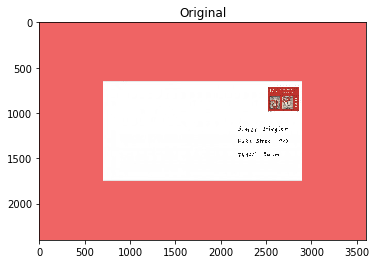

In [3]:
    # Lesen des Bilds
image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
height,width,channels = image.shape
height-=1
width-=1
showImage = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # Zeigen des Bilds
plt.imshow(showImage)
plt.title("Original")

## For Rotating the Picture
https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/

Text(0.5, 1.0, 'blurred')

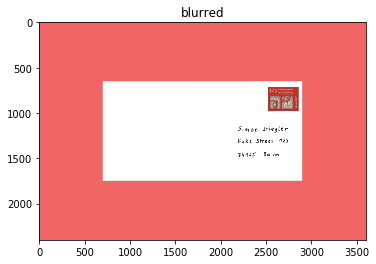

In [4]:
    # Gausian Blur
blurred  = cv2.GaussianBlur(image, (blurring,blurring) , 2, 2,cv2.THRESH_BINARY)
blurredShow = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
plt.imshow(blurredShow)
plt.title("blurred")

## Binarisierung
https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

Text(0.5, 1.0, 'Gray')

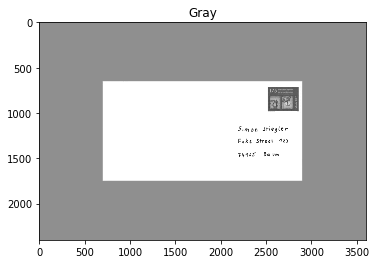

In [5]:
# thresh1 = cv2.adaptiveThreshold(blurred,255,125,cv2.THRESH_BINARY,11,5)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.title("Gray")

Text(0.5, 1.0, 'Canny')

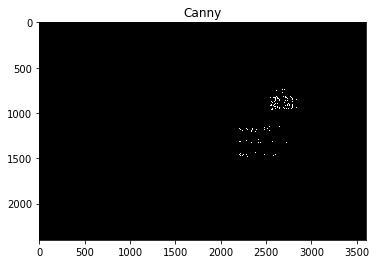

In [6]:
canny = cv2.Canny(gray,0,30)
height,width = canny.shape
plt.imshow(canny, cmap="gray")
plt.title("Canny")

Text(0.5, 1.0, 'dilate')

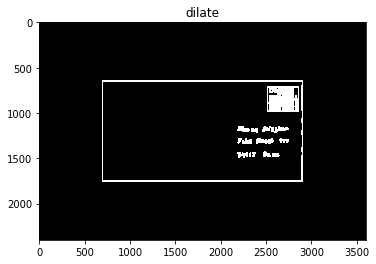

In [7]:
dilate = cv2.dilate(canny,dilateKernel,iterations=1)
plt.imshow(dilate, cmap="gray")
plt.title("dilate")

Text(0.5, 1.0, 'erode')

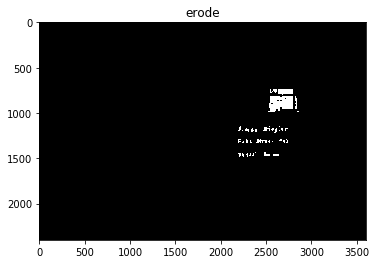

In [8]:
erode = cv2.erode(dilate,erodeKernel,iterations=1)
plt.imshow(erode, cmap="gray")
plt.title("erode")

In [9]:
def align_straight(image):
    img,contours,hierachies = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for index,hierachy in enumerate(hierachies):
        hNext, hPrev, hChild, hParent = hierachy[0]
        if (hChild != -1) and (hParent == -1):      #Extract Parent contour
            contour = contours[0][index]
    center,[letter_W,letter_H],angle = cv2.minAreaRect(contours[1])
    print (center,[letter_W,letter_H],angle)
    if letter_W < letter_H:
        aligned_image = im.rotate_bound(image,-angle+90)
    else:
        aligned_image = im.rotate_bound(image,-angle)
    return aligned_image  

(1799.0, 1200.0) [2198.0, 1098.0] -0.0


Text(0.5, 1.0, 'straight-aligned')

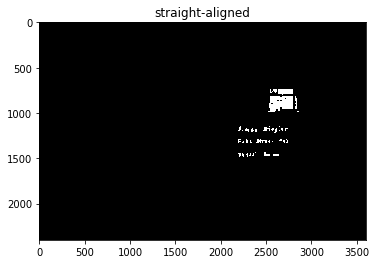

In [10]:
aligned_image = align_straight(erode)
plt.imshow(aligned_image,cmap="gray")
plt.title("straight-aligned")

In [11]:
img,contours,hierachy = cv2.findContours(erode,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# Hierarchie [Previous, Next, Child, Parent]

In [12]:
def sizeSort(element):
    return len(element)
contours.sort(reverse=True,key=sizeSort)
for index,contour in enumerate(contours):
    if(index<6):
        print(contour.size)

13178
13176
4368
2458
1250
674


## Get the Moments
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [13]:
# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
def findLetter(contours):
    for contour in contours:
    #( center (x,y), (width, height), angle of rotation ).
        minArea = cv2.minAreaRect(contour)
        width = minArea[1][0]
        height = minArea[1][1]
        scale = width/height
        if(scale>C_5_6_Scale[0] and scale<C_5_6_Scale[1]):
            letter = {
                "width": int(width),
                "height" : int(height),
                "centerX" : int(minArea[0][0]),
                "centerY" : int(minArea[0][1]),
                "contour": contour
                }
            return letter

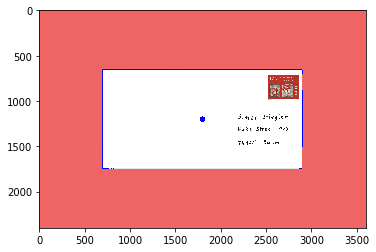

In [14]:
letterValue = findLetter(contours)
# Highlight the Contour of Find Letter and show center of Letter
highlightedContour = showImage.copy()
highlightedContour = cv2.circle(highlightedContour,(letterValue["centerX"],letterValue["centerY"]),radius=30, color=(0,0,255),thickness=-1)
cv2.drawContours(highlightedContour, letterValue["contour"], -1, (0, 0, 255), 7) 
plt.imshow(highlightedContour)

## ROI of Letter

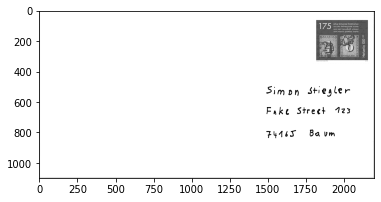

In [15]:
xStart = int(letterValue["centerX"]-letterValue["width"]/2)
xEnd = int(letterValue["centerX"]+letterValue["width"]/2)
yStart = int(letterValue["centerY"]-letterValue["height"]/2)
yEnd = int(letterValue["centerY"]+letterValue["height"]/2)
letter = gray[yStart:yEnd,xStart:xEnd]
plt.imshow(letter, cmap="gray")

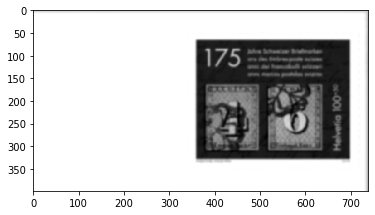

In [16]:
pixelPerMM = letterValue["width"]/C_5_6_Metrics[0]
# StampZone [width, height] amount of Pixel
stampZoneMetrics = [int(stampZone[0]*pixelPerMM),int(stampZone[1]*pixelPerMM)]
# get the rigth Top StampZone
rightTop = letter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
plt.imshow(rightTop, cmap="gray")

### Check if stamp is there

In [17]:
def checkStamp(stampZone, pixelPerMM):
    imgStamp,cStamp,hStamp = cv2.findContours(stampZone,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    if (len(cStamp)==0):                #No contour found
        return False
    for index,contour in enumerate(cStamp):         
        #( center (x,y), (width, height), angle of rotation ).
        hNext, hPrev, hChild, hParent = hStamp[0][index]
        if (hChild != -1) and (hParent == -1):      #Extract Parent contour
            #TBD: If there are some contours beside the stemp the first and/or second condition would be FALSE...
            minArea = cv2.minAreaRect(contour)
            width = minArea[1][0]
            height = minArea[1][1]
            # stamp minSize 22x28
            contourWidth = width/pixelPerMM
            contourHeigth = height/pixelPerMM
            if((contourWidth >= stampMinSize[0]) and (contourHeigth >= stampMinSize[1])):
                stamp_found = True
            else:
                stamp_found = False
    return stamp_found

def align_correct(roiLetter,pixelPerMM):
    # StampZone [width, height] amount of Pixel
    stampZoneMetrics = [int(stampZone[0]*pixelPerMM),int(stampZone[1]*pixelPerMM)]
    # get the rigth Top StampZone
    rightTop = roiLetter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
    stamp_found = checkStamp(rightTop,pixelPerMM)      
    if stamp_found:
        return roiLetter
    else:
        return im.rotate_bound(roiLetter,180)


In [18]:
coorect_alligned = align_correct(im.rotate_bound(letter,180),pixelPerMM)
plt.imshow(coorect_alligned, cmap ="gray")
plt.title("correct-aligned")

UnboundLocalError: local variable 'stamp_found' referenced before assignment

## Get AddressField

In [ ]:
height, width = letter.shape
pixelMargin = margin*pixelPerMM
addressField = letter.copy()
startX = int(pixelMargin)
endX = int(width-pixelMargin)
startY = int(stampZone[1]*pixelPerMM)
endY = int(height-pixelMargin)
addressField = addressField[startY:endY,startX:endX]
plt.imshow(addressField, cmap="gray")

In [ ]:
th, binAF = cv2.threshold(addressField, 128, 255, cv2.THRESH_BINARY)
plt.imshow(binAF,cmap="gray")

In [ ]:
imgAF,contoursAF,hierachyAF = cv2.findContours(binAF,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
heightAF,widthAF = addressField.shape
plt.imshow(imgAF,cmap="gray")
contourImg = np.zeros((heightAF,widthAF,3))
for index,contour in enumerate(contoursAF):
    r = random()
    g = random()
    b = random()
    cv2.drawContours(contourImg,contoursAF , index, (r,g,b), 5) 
plt.imshow(contourImg)

## Display Function
https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

In [ ]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## Extract the Characters

In [ ]:
print(hierachyAF[0][4])

In [ ]:
characters = []
for index,contour in enumerate(contoursAF):
    # [x,y,width,height]
    rect = cv2.boundingRect(contour)
    x = rect[0]
    y = rect[1]
    width = rect[2]
    height = rect[3]
    # 0 because of the outer
    if(width>5 and height>5 and width!=widthAF and hierachyAF[0][index][3]==0):
        img = binAF[y:y+height,x:x+width]
        character = {
                "img": img,
                "width" : width,
                "height" : height,
                "x" : x,
                "y": y
                }
        characters.append(character)
        # plt.imshow(character,cmap="gray")
show_images(pydash.map_(characters,"img")) 

In [ ]:
centerPoints = characters
print(pydash.map_(characters,["x"]))
print(pydash.map_(characters,["y"]))

In [ ]:
mean_width = np.sum(pydash.map_(characters,"width"))/len(characters)
mean_height = np.sum(pydash.map_(characters,"height"))/len(characters)
def sortY(element):
    return element["y"]
centerPoints.sort(key=sortY)
print(mean_width)
print(mean_height)
print(pydash.map_(characters,["x"]))
print(pydash.map_(characters,["y"]))

## Get the Rowedges

In [ ]:
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
amount, binEdges, _  = plt.hist(pydash.map_(characters,["y"]), bins="auto")
rowEdges = []
for i,yValue in enumerate(amount):
    if(yValue>0):
        rowEdges.append([binEdges[i],binEdges[i+1]])


print(rowEdges)
print(amount)

## Get the Rows

In [ ]:
rows = []
lastChar = characters[len(characters)-1]
for edge in rowEdges:
    rowElements = []
    for index,character in enumerate(characters):
        if(edge[0]<=character["y"]): 
            if(edge[1]>=character["y"]):
                rowElements.append(character)
                # for last Edge that the rowElements are added
                if(lastChar==character):
                    rows.append(rowElements)
            else:
                rows.append(rowElements)
                break
print(len(rows))

## Displaying the Rows

In [ ]:
def sortX(element):
    return element["x"]

for row in rows:
    row.sort(key=sortX)
    show_images(pydash.map_(row,"img")) 

## Get PLZ
From Last Row

https://www.sekretaria.de/bueroorganisation/korrespondenz/din-5008/anschrift/

In [ ]:
lastRow = rows[len(rows)-1]
PLZ = lastRow[0:5]
show_images(pydash.map_(PLZ,"img"))

### Bekomme den Stream der Kamera und verwandle es in ein grau Stufen Bild
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html?highlight=video

In [ ]:
# cap = cv2.VideoCapture(0)

# while(True):
#     # Capture frame-by-frame
#     ret, frame = cap.read()

#     # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=imshow
#     #canny Edge Detection
#     edges = cv2.Canny(gray,100,200)
#     # 1 Fenster mit Graustufe
#     namedWindow1 = "gray"
#     cv2.namedWindow(namedWindow1)
#     cv2.moveWindow(namedWindow1,0,0)
#     cv2.imshow(namedWindow1, gray)
#     # 2 Fenster mit Kantenbild
#     namedWindow2 = "edges"
#     cv2.namedWindow(namedWindow2)
#     cv2.moveWindow(namedWindow2,640,0)
#     cv2.imshow(namedWindow2,edges)
#     # 3 Fenster 
#     namedWindow3 = "weiteres"
#     cv2.namedWindow(namedWindow3)
#     cv2.moveWindow(namedWindow3,1280,0)
#     cv2.imshow(namedWindow3,edges)


#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()

In [ ]:
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Abgleich mit Datenbank

In [ ]:
def get_town(plz):
    # Verbindung, Cursor
    connection = sqlite3.connect("orteDE.db")
    cursor = connection.cursor()

    # SQL-Abfrage
    sql = "SELECT ortsname, bundesland FROM orte WHERE plz="+str(plz)

    # Kontrollausgabe der SQL-Abfrage
    # print(sql) 

    # Absenden der SQL-Abfrage
    # Empfang des Ergebnisses
    cursor.execute(sql)

    # Ausgabe des Ergebnisses
    results = cursor.fetchall()
    #for dsatz in cursor:
    #    ort = dsatz[0]
    #    bundesland = dsatz[1]
        
    # Verbindung beenden
    connection.close()

    return results

In [ ]:
#Example for single PLZ
print(get_town(74246))
#Example for multiple PLZ
print(get_town(27367))